# Chapter 2: Evaluation Versus Instruction

## Exercise 2.1

> In ε-greedy action selection, for the case of two actions and ε = 0.5, what is the probability that the greedy action is selected?

$$
\begin{align*}
P(greedy) &= P(\text{greedy strategy}) + P(greedy \vert \text{explore strategy}) \\
&= 0.5 + (0.5*0.5) \\
&= 0.75 \\
\end{align*}
$$

## Exercise 2.2: Bandit Example

> Consider a k-armed bandit problem with $k = 4$ actions, denoted 1, 2, 3, and 4. Consider applying to this problem a bandit algorithm using ε-greedy action selection, sample-average action-value estimates, and initial estimates of $Q_1(a) = 0$, for all $a$. Suppose the initial sequence of actions and rewards is $A_1$ = 1, $R_1$ = 1, $A_2$ = 2, $R_2$ = 1, $A_3$ = 2, $R_3$ = 2, $A_4$ = 2, $R_4$ = 2, $A_5$ = 3, $R_5$ = 0. On some of these time steps the ε case may have occurred, causing an action to be selected at random. On which time steps did this definitely occur? On which time steps could this possibly have occurred?

| $k$ | $A_k$ | $R_k$ | $Q_k$ | Random? |
|-----|-------|-------|----------|---------|
| 1   | 1     | 1     | 1        | Yes     |
| 2   | 2     | 1     | 1        | Yes     |
| 3   | 2     | 2     | $3/2$    | Maybe   |
| 4   | 2     | 2     | $5/3$    | Maybe   |
| 5   | 3     | 0     | 0        | Yes     |


In [12]:
from collections import defaultdict
import math
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline

import seaborn as sns
sns.set()

def seed(s):
    random.seed(s)
    np.random.seed(s)

In [2]:
import gym
from gym import spaces
from typing import *

class Info(NamedTuple):
    optimal_play: bool
    
class Observation(NamedTuple):
    state: None
    reward: float
    done: bool
    info: Info

class BanditEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, n_arms, q_mean=0):
        self.n_arms = n_arms
        self.q_mean = q_mean
        
        self.action_space = spaces.Discrete(n_arms)
        self.observation_space = None
        self.reset()
        
    def reset(self):
        self.arms = [random.gauss(self.q_mean, 1.) for i in range(self.n_arms)]
        return None # Don't leak the secret state sauce.
            
    def step(self, action):
        optimal_action = self.arms.index(max(self.arms))
        info = Info(action == optimal_action)
        q = self.arms[action]
        reward = random.gauss(q, 1.0)
        
        return Observation(None, reward, False, info)
    
    def render(self, mode='human'):
        print('Arms: {}'.format(self.arms))
        
ten_arm = BanditEnv(10)
ten_arm.step(ten_arm.action_space.sample())

Observation(state=None, reward=-2.2356584866188376, done=False, info=Info(optimal_play=False))

In [10]:
class BanditAgent(object):
    def __init__(self, env):
        self.env = env
        self.reset()
        
    def reset(self):
        self.q_sum = [0] * self.env.n_arms
        self.k = [0] * self.env.n_arms
        self.q = [0] * self.env.n_arms
    
    def choose(self):
        raise NotImplemented()
    
    def act(self):
        action = self.choose()
        observation = self.env.step(action)

        self.q_sum[action] += observation.reward
        self.k[action] += 1
        self.q[action] = self.q_sum[action] / self.k[action]
        return observation
    

class EpsilonGreedyAgent(BanditAgent):
    def __init__(self, env, epsilon):
        super().__init__(env)
        self.epsilon = epsilon
        
    def choose(self):
        explore = np.random.random() < self.epsilon
        if explore:
            return self.env.action_space.sample()
        else:
            return self.q.index(max(self.q))

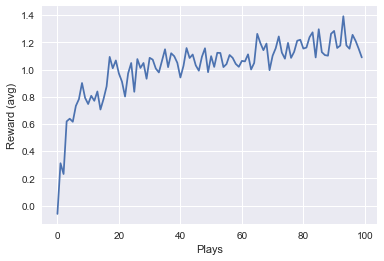

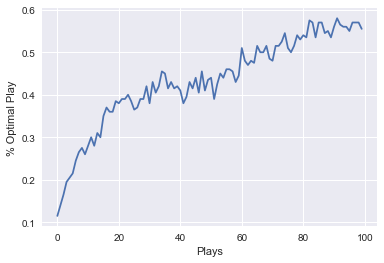

In [11]:
class TrialResult(NamedTuple):
    rewards: np.ndarray
    optimal_play: np.ndarray
    
    def plot_rewards(self, ax, label=None):
        ax.set_xlabel('Plays')
        ax.set_ylabel('Reward (avg)')
        
        avg_reward = self.rewards.mean(axis=0)
        xs = np.arange(0, len(avg_reward))
        ax.plot(xs, avg_reward, label=label)
        
    def plot_optimal(self, ax, label=None):
        ax.set_xlabel('Plays')
        ax.set_ylabel('% Optimal Play')
        
        avg_optimal = self.optimal_play.mean(axis=0)
        xs = np.arange(0, len(avg_optimal))
        ax.plot(xs, avg_optimal, label=label)

class Trial(object):
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        
    def run(self, trials=2000, plays=1000):
        shape = (trials, plays)
        results = TrialResult(np.zeros(shape), np.zeros(shape))
        for trial in range(trials):
            self.env.reset()
            self.agent.reset()
            for play in range(plays):
                observation = self.agent.act()
                results.rewards[trial, play] = observation.reward
                results.optimal_play[trial, play] = 1. if observation.info.optimal_play else 0.
                
        return results
    

agent = EpsilonGreedyAgent(ten_arm, 0.1)
results = Trial(ten_arm, agent).run(200, 100)
results.plot_rewards(plt.gca())
plt.show()
results.plot_optimal(plt.gca())

## Exercise 2.3

> In the comparison shown in Figure 2.2, which method will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be? Express your answer quantitatively.

$\epsilon = 0.01$ will perform better in the long run, because while all values of $\epsilon$ will converge to $q_*(a)$, smaller values of $\epsilon$ will choose the greedy action more often.

For any value of $\epsilon > 0$, the % optimal play will converge to $(1-\epsilon) + (\frac{\epsilon}{n})$. $\epsilon = 0.1$ will converge to 0.91, and $\epsilon = 0.01$ will converge to 

Text(0.5,1,'Figure 2.2')

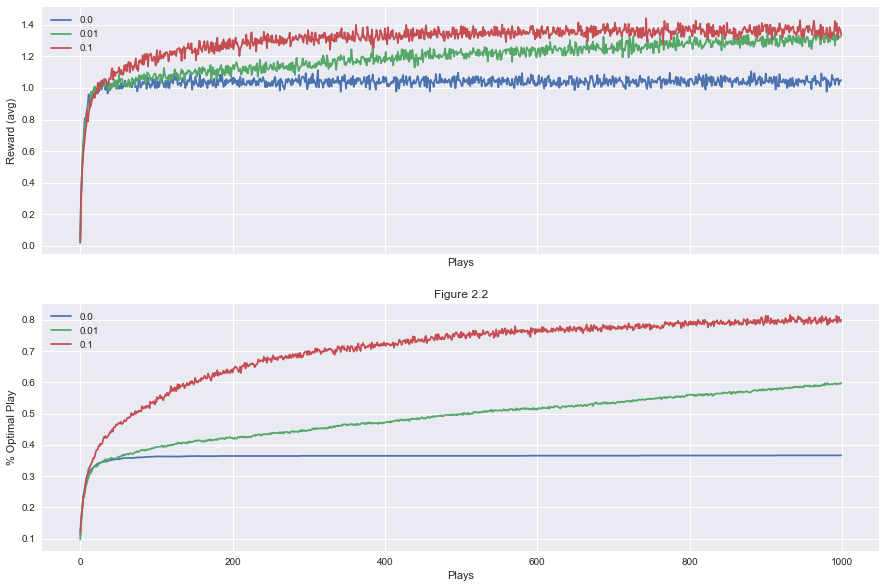

In [18]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,10))

for epsilon in [0., 0.01, 0.1]:
    agent = EpsilonGreedyAgent(ten_arm, epsilon)
    results = Trial(ten_arm, agent).run()
    results.plot_rewards(axes[0], str(epsilon))
    results.plot_optimal(axes[1], str(epsilon))
for ax in axes:
    ax.legend()
plt.title('Figure 2.2')

## Exercise 2.4
> If the step-size parameters, $α_n$, are not constant, then the estimate $Q_n$ is a weighted
average of previously received rewards with a weighting different from that given by (2.6). What is
the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of
step-size parameters?

## Exercise 2.2

> How does the softmax action selection method using the Gibbs distribution fare on the 10-armed testbed?

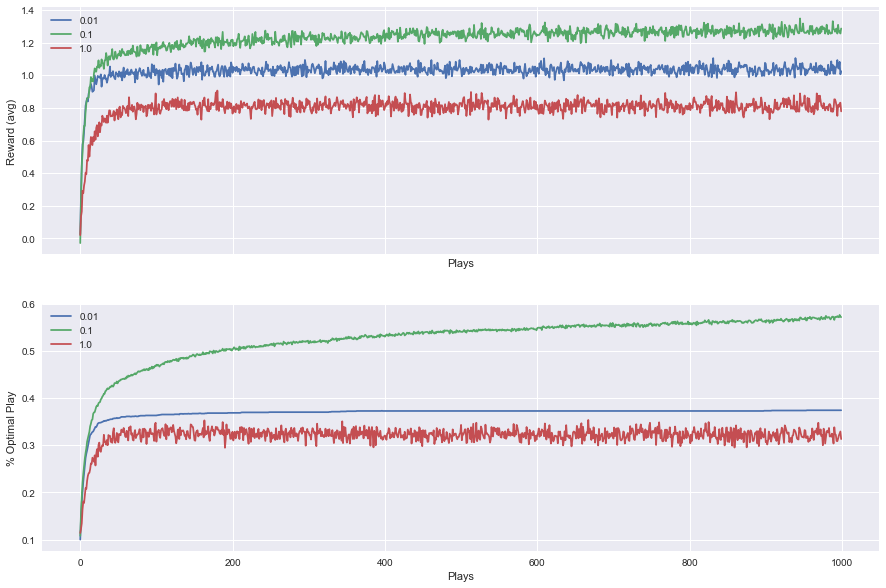

In [17]:
class SoftmaxAgent(BanditAgent):
    def __init__(self, env, temp):
        super().__init__(env)
        self.temp = temp
    
    def choose(self):
        denom = sum(math.exp(q_b/self.temp) for q_b in self.q)
        weights = [math.exp(q_a/self.temp) / denom for q_a in self.q]
        choice = random.choices(self.q, weights=weights, k=1)
        return self.q.index(choice[0])
    
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,10))

for temp in [0.01, 0.1, 1.]:
    agent = SoftmaxAgent(ten_arm, temp)
    results = Trial(ten_arm, agent).run()
    results.plot_rewards(axes[0], str(temp))
    results.plot_optimal(axes[1], str(temp))
for ax in axes:
    ax.legend()

## ★Exercise 2.3 

> Show that in the case of two actions, the softmax operation using the Gibbs distribution becomes the logistic, or sigmoid, function commonly used in artificial neural networks. What effect does the temperature parameter have on the function?

## Exercise 2.4

> Consider a class of simplified supervised learning tasks in which there is only one situation (input pattern) and two actions. One say, say _a_, is correct and the other, _b_, is incorrect. The instruction signal is noisy: it instructs the wrong action with probability _p_; that is, with probability _p_ it says that _b_ is correct. You can think of these tasks as binary bandit tasks if you treat agreeing with the (possibly wrong) instruction signal as _success_, and disagreeing with it as _failure_. Discuss the resulting class of binary bandit tasks. Is anything special about these tasks? How does the supervised algorithm perform on these tasks?